# Benchmarking MOM6

In this example we'll install MOM6 on CentOS7 Linux system. Then, we'll run a simple, quick benchmarking MOM6 run.

**Prerequisite Tools:** <br>
If your machine doesn't have the following tools installed, please install them now.
 


    sudo yum install git tcsh pkg-config
    sudo yum install gfortran
    sudo yum install netcdf-bin libnetcdf-dev libnetcdff-dev
    sudo yum install openmpi-bin libopenmpi-dev
    sudo yum install libnetcdff-dev

#### 1) Clone the MOM6 Examples Repository

    git clone --recursive https://github.com/NOAA-GFDL/MOM6-examples.git
    cd MOM6-examples

#### 2) Load modules and prepare directories

    module load netcdf-fortran
    mkdir -p build/gnu/shared/repro/

#### 3) Compile

    (cd build/gnu/shared/repro/; rm -f path_names; \
    ../../../../src/mkmf/bin/list_paths -l ../../../../src/FMS; \
    ../../../../src/mkmf/bin/mkmf -t ../../../../src/mkmf/templates/triton-gnu.mk -p libfms.a -c "-Duse_libMPI -Duse_netCDF" path_names)


    (cd build/gnu/shared/repro/; source ../../env; make NETCDF=3 REPRO=1 libfms.a -j)
    
    
    mkdir -p build/gnu/ocean_only/repro/
    (cd build/gnu/ocean_only/repro/; rm -f path_names; \
    ../../../../src/mkmf/bin/list_paths -l ./ ../../../../src/MOM6/{config_src/infra/FMS1,config_src/memory/dynamic_symmetric,config_src/drivers/solo_driver,config_src/external,src/{*,*/*}}/ ; \
    ../../../../src/mkmf/bin/mkmf -t ../../../../src/mkmf/templates/triton-gnu.mk -o '-I../../shared/repro' -p MOM6 -l '-L../../shared/repro -lfms' path_names)
    
    
    (cd build/gnu/ocean_only/repro/; source ../../env; make NETCDF=3 REPRO=1 MOM6 -j)

#### 4) Create softlinks and directories 

    cd ocean_only/benchmark
    ln -s ../../build/gnu/ocean_only/repro/MOM6 .
    mkdir -p RESTART

#### 5) Run the model

    salloc -N 1
    prun ./MOM6

## Analyze the Output

The output file we are concerned with is called `prog.nc` and is located in our `benchmark` directory. `scp` this file to your local machine or a machine you can perform visual analysis on.

We are going ot use xarray to inspect the output.

In [10]:
import xarray as xr
progFile = xr.open_dataset('/Users/james/Downloads/prog.nc')
progFile.data_vars

Data variables:
    u        (time, zl, yh, xq) float32 ...
    v        (time, zl, yq, xh) float32 ...
    h        (time, zl, yh, xh) float64 ...
    e        (time, zi, yh, xh) float32 ...
    temp     (time, zl, yh, xh) float32 ...

In [11]:
progFile.dims

Frozen(SortedKeysDict({'xq': 361, 'yh': 180, 'zl': 22, 'time': 1, 'xh': 360, 'yq': 181, 'zi': 23}))

Notice our horizontal shape (360 by 180 grid centers), our vertical levels (22 levels), and our time (1 time). The benchmark nature of this experiment leaves us with only 1 value in the time dimension. In a formal MOM6 run, the time dimension can become so large that the use of big data python packages such as `dask` may be required to analyze the data. Let's inspect our `temp` variable. 

In [12]:
progFile.temp

<xarray.DataArray 'temp' (time: 1, zl: 22, yh: 180, xh: 360)>
[1425600 values with dtype=float32]
Coordinates:
  * yh       (yh) float64 -40.89 -40.7 -40.51 -40.32 ... -0.625 -0.375 -0.125
  * zl       (zl) float64 1.029e+03 1.03e+03 1.03e+03 ... 1.037e+03 1.037e+03
  * time     (time) object 0001-01-02 00:00:00
  * xh       (xh) float64 0.125 0.375 0.625 0.875 ... 89.12 89.38 89.62 89.87
Attributes:
    long_name:     Potential Temperature
    units:         degC
    cell_methods:  area:mean zl:mean yh:mean xh:mean time: point

Let's inspect the top layer of potential temperature. Our vertical dimension is potential density, so let's show what the top value is numerically. 

In [16]:
progFile.zl[0]

<xarray.DataArray 'zl' ()>
array(1028.93519697)
Coordinates:
    zl       float64 1.029e+03
Attributes:
    long_name:       Layer Target Potential Density
    units:           kg m-3
    cartesian_axis:  Z
    positive:        up

Since we only have 1 time value, we know that will be the 0th index of the time dimension.

Text(0.5, 1.0, 'Potential Temperature at Potential Density of 1028.94 kg m-3')

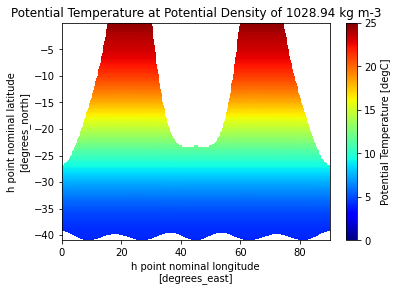

In [25]:
prog_file.temp[0][0].plot(vmin=0, vmax=25, cmap='jet')
plt.title("Potential Temperature at Potential Density of " + str(round(float(progFile.zl[0].values),2)) + " " + str(progFile.zl.units))

Now let's choose a vertical level in the middle of our vertical dimension

Text(0.5, 1.0, 'Potential Temperature at Potential Density of 1035.23 kg m-3')

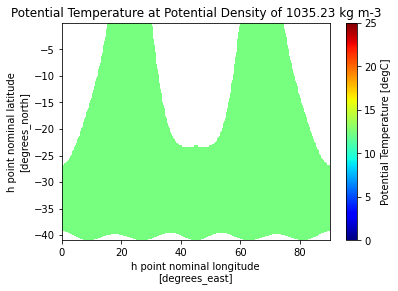

In [27]:
prog_file.temp[0][11].plot(vmin=0, vmax=25, cmap='jet')
plt.title("Potential Temperature at Potential Density of " + str(round(float(progFile.zl[11].values),2)) + " " + str(progFile.zl.units))